In [7]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score


merged_data = pd.read_csv("merged_data.csv")

X = merged_data[
    [
        "Wealth",
        # "Opportunities",
        "Career Years",
        "Sex",
        "Job",
        "Has Disease",
        "Has Car",
        "Has House",
        # "Job Loss Probability",
        # "Reproduction Chance",
        "Child Possibility",
        "Personal Luxuries",
        "Healthcare Cost"
    ]
]
y = merged_data["Group"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

y.value_counts()

Group
1    19559
0    12316
Name: count, dtype: int64

In [8]:
model = joblib.load("models/LightGBM.pkl")
y_pred = model.predict(X_test)

job = X_test["Has Disease"]

mf = MetricFrame(
    metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=job
)

print("Overall Metric Frame: ", mf.overall)
print("\nMetric Frame by group: ", mf.by_group)

Overall Metric Frame:  0.6584753738366621

Metric Frame by group:  Has Disease
False    0.780435
True     0.489005
Name: accuracy_score, dtype: float64


The	Overall Metric Frame (0.6629) represents the specified overall performance metric (accuracy) across all groups combined. The value of 0.6629 suggests that the model’s accuracy is about 66.3% when evaluated on the entire dataset, without differentiating by groups.

The Metric Frame by Group (regarding Job) evaluates the model’s accuracy score for specific groups within the feature Job, divided into two categories, False and True:

- False (0.4304): For the group labeled False under Job, the model has an accuracy score of 43.0%. This indicates a notably lower performance for this group compared to the overall accuracy.
- True (0.6792): For the group labeled True under Job, the accuracy is 67.9%, which is closer to the overall accuracy score and significantly better than the False group.

array([[<Axes: title={'center': 'accuracy'}, xlabel='Has Disease'>,
        <Axes: title={'center': 'precision'}, xlabel='Has Disease'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Has Disease'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Has Disease'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Has Disease'>,
        <Axes: title={'center': 'count'}, xlabel='Has Disease'>],
       [<Axes: xlabel='Has Disease'>, <Axes: xlabel='Has Disease'>,
        <Axes: xlabel='Has Disease'>]], dtype=object)

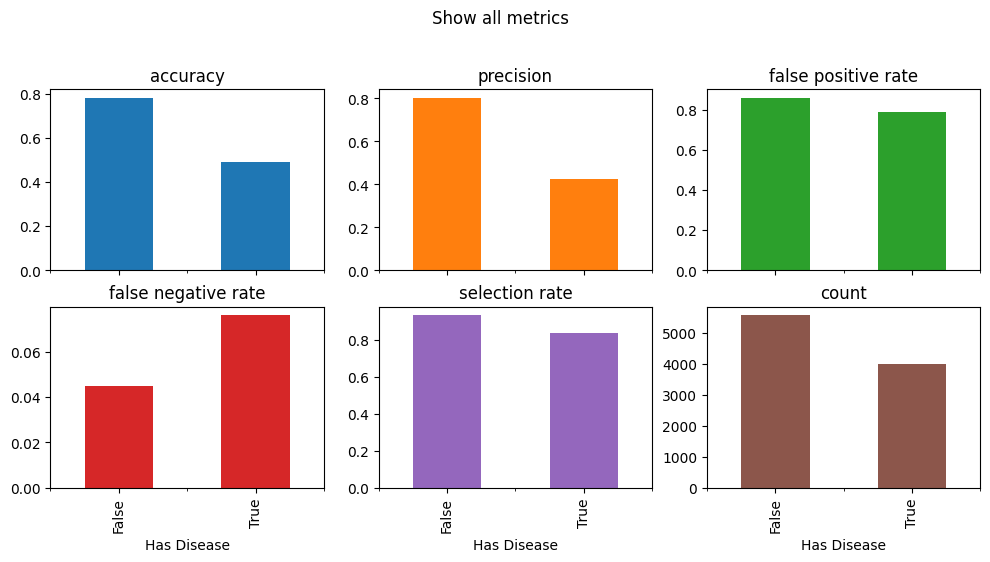

In [9]:
from fairlearn.metrics import (MetricFrame,  false_positive_rate,
    false_negative_rate, selection_rate, count)
from sklearn.metrics import (
    accuracy_score,
    precision_score
)

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=job
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [11]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient

np.random.seed(42)

constraint = DemographicParity()
job = X_train["Job"]
mitigator = ExponentiatedGradient(model, constraint)
mitigator.fit(X_train, y_train, sensitive_features=job)

y_pred_mitigated = mitigator.predict(X_test)

job = X_test["Job"]
sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=job)

sr_mitigated.overall

np.float64(0.6680957858412632)

In [12]:
sr_mitigated.by_group

Job
False    0.657865
True     0.669121
Name: selection_rate, dtype: float64